In [1]:
import os
import sys
import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from PIL import Image
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 加载数据
可视化数据

In [2]:
train, test = cifar10.load_data()
train_x, train_y, test_x, test_y = train[0], train[1].reshape(-1), test[0], test[1].reshape(-1)

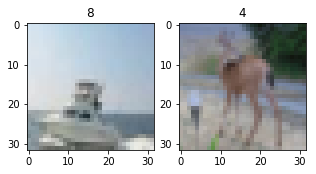

In [3]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(train_x[100])
plt.title(train_y[100])
plt.subplot(1,2,2)
plt.imshow(test_x[100])
plt.title(test_y[100])
plt.show()

# 编写dataloader
数据生成器，用于训练

In [4]:
class DataGen(Dataset):
    def __init__(self, data, label, transforms=None):
        self.data = data
        self.label = label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img = self.data[index]
        tag = self.label[index]
        if self.transforms:
            img = Image.fromarray(img.astype('uint8'))
            img = self.transforms(img)
        return img, tag

    def __len__(self):
        return self.data.shape[0]

In [5]:
traingen = DataGen(train_x, train_y, transforms=transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                                                    transforms.RandomRotation(degrees=20),
                                                                    transforms.RandomVerticalFlip(p=0.5),
                                                                    transforms.ToTensor()]))
trainloader = DataLoader(dataset=traingen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=False,
                         shuffle=True,
                         num_workers=10)
testgen = DataGen(test_x, test_y, transforms=transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(dataset=testgen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=False,
                         shuffle=True,
                         num_workers=10)

## 测试dataloader

In [6]:
loader = iter(trainloader)
img, tag = next(loader)
print('img shape',img.shape,'tag shape',tag.shape)

img shape torch.Size([32, 3, 32, 32]) tag shape torch.Size([32])


# 创建模型

In [7]:
# 等价于删除某个层
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


def resnet18():
    res18 = models.resnet18(pretrained=True)
    res18.fc = Identity()  # 最后一层全连接删除
    res18.avgpool = Identity() # 全局平均池化也需要更改，原始的224降低32x，现在32降低32x成了1
    return res18
    
    
class ResNet18(torch.nn.Module):
    def __init__(self, categroies):
        super(ResNet18, self).__init__()
        self.resnet18 = resnet18()
        self.fc = torch.nn.Linear(512, categroies)
        
    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        return x


In [8]:
model = ResNet18(10)
# 交叉熵内部做softmax，所以模型的最后一层不需要加softmax激活函数
criterion = torch.nn.CrossEntropyLoss()
# 做微调，那么最后一层全连接学习率设大一些，base model则设小一些
param_groups = [
    {'params':model.fc.parameters(),'lr':.001},
    {'params':model.resnet18.parameters(),'lr':.0001},
]
# adam默认是1e-3的学习率，如果没有在groups中设置的话，则会是默认，设置了的话就会更新为设置的
optimizer = torch.optim.Adam(params=param_groups)

In [9]:
model.eval() # 模型训练阶段如果含有bn层的话，是无法使用batch_size = 1
test = model(torch.rand(1,3,32,32))
test.size()

torch.Size([1, 10])

# 开始训练

In [10]:
epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
for i in range(epochs):
    train_correct = 0
    train_total = 0
    for (img, tag) in tqdm(trainloader):
        img = img.to(device)
        tag = tag.to(device).type(torch.cuda.LongTensor)
        # print(tag)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == tag).sum().item()
        train_total += tag.shape[0]
        loss = criterion(output, tag)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('############## taining ##############')
    print('{}/{}, loss:{}, training Accuracy:{}'.format(i+1, epochs, loss.item(), train_correct / train_total))
    print('############## taining ##############')
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for img, tag in tqdm(testloader):
            img = img.to(device)
            tag = tag.to(device).type(torch.cuda.LongTensor)
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == tag).sum().item()
            total += tag.shape[0]
        print('############## testing ##############')
        print('testing Average Accuracy is {}'.format(correct / total))  
        print('############## testing ##############')

  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
1/10, loss:0.6325461864471436, training Accuracy:0.54392
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.6565
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
2/10, loss:1.0968945026397705, training Accuracy:0.64764
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.6634
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
3/10, loss:0.9575943946838379, training Accuracy:0.6843
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7191
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
4/10, loss:1.037312388420105, training Accuracy:0.70872
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7296
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
5/10, loss:0.4431699812412262, training Accuracy:0.7225
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.731
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
6/10, loss:0.9629826545715332, training Accuracy:0.73672
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7434
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
7/10, loss:0.4655568301677704, training Accuracy:0.7488
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7664
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
8/10, loss:0.8745599985122681, training Accuracy:0.75936
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7675
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
9/10, loss:0.5323635339736938, training Accuracy:0.76838
############## taining ##############


  0%|          | 0/1563 [00:00<?, ?it/s]

############## testing ##############
testing Average Accuracy is 0.7637
############## testing ##############


  0%|          | 0/313 [00:00<?, ?it/s]

############## taining ##############
10/10, loss:0.40657275915145874, training Accuracy:0.77724
############## taining ##############


100%|██████████| 313/313 [00:02<00:00, 145.49it/s]

############## testing ##############
testing Average Accuracy is 0.7709
############## testing ##############
